In [47]:
import os
from seabird.cnv import fCNV
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [24]:
# directory where .cnv files are saved
# you can use this with cruise 1 or cruise 2 data
datadir = 'data_cruise2'

stnCounter=0
stnnames=[]
# loop through all cnv files
for filename in os.listdir(datadir):
    if filename.endswith(".cnv"):
        # keep count of number of files
        stnCounter += 1
        
        # combine path and file name in string
        pathfile = datadir+'/'+filename
        #print(pathfile)
        
        # create a list of station names
        m = filename.index('_')
        stnnames.append(filename[:m])
        #print(stnnames)
        
        # use seabird software to read cnv file
        cast = fCNV(pathfile)
    
        latitude, longitude    = cast.attributes['LATITUDE'], cast.attributes['LONGITUDE']
    
        pressure    = cast['PRES']
        temperature = cast['TEMP'] 
        salinity    = cast['PSAL']
        
        if stnCounter == 1:
            Ts = pd.Series(data=cast['TEMP'],index=cast['PRES'],name=cast)
            Ss = pd.Series(data=cast['PSAL'],index=cast['PRES'],name=cast)
            pHs = pd.Series(data=cast['ph'],index=cast['PRES'],name=cast)
        else:
            Ts = pd.concat([Ts,pd.Series(data=cast['TEMP'],index=cast['PRES'],name=cast)],axis=1)
            Ss = pd.concat([Ss,pd.Series(data=cast['PSAL'],index=cast['PRES'],name=cast)],axis=1)   
            pHs = pd.concat([pHs,pd.Series(data=cast['ph'],index=cast['PRES'],name=cast)],axis=1)

        lons, lats = [],[]
        
        # Attributes to feed data array
        lons.append(latitude)
        lats.append(longitude) 
        

In [25]:
# Dataframe to DataArray
Txr = Ts.stack().to_xarray().rename({'level_0' : 'pressure', 'level_1' : 'cast'})
Txr.name = 'temperature'
Sxr = Ss.stack().to_xarray().rename({'level_0' : 'pressure', 'level_1' : 'cast'})
Sxr.name = 'salinity'
pHxr = pHs.stack().to_xarray().rename({'level_0' : 'pressure', 'level_1' : 'cast'})
pHxr.name = 'pH'

In [26]:
ctdcombined = xr.merge([Txr,Sxr,pHxr])
#ctdcombined

In [27]:
ctdcombined.pressure.attrs['units'] = 'dbar'
ctdcombined.temperature.attrs['units'] = 'degree C'
ctdcombined.salinity.attrs['units'] = 'psu'

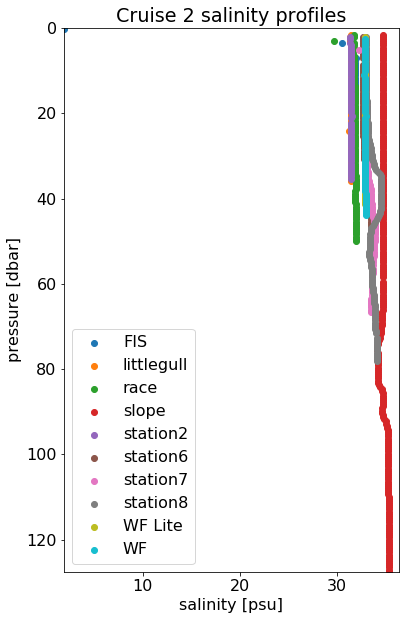

In [53]:
ylim = (ctdcombined.pressure.values.max(),0)

# Should be able to use the min and max of the data to determine the x axis limits
# but there is a zero point at surface FIS skews axis
#xlim = (np.nanmin(ctdcombined.salinity.values-1),np.nanmax(ctdcombined.salinity.values)+1)

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(6,10))
for i in range(stnCounter):
    ctdcombined.isel(cast=i).plot.scatter('salinity','pressure',label=stnnames[i])
plt.legend(loc=3)
plt.xlim([29, 36])
#plt.xlim(*xlim)
plt.ylim(*ylim)
plt.title("Cruise 2 salinity profiles")

plt.savefig('Figures/Cruise2salinity.png')

In [39]:
ylim

(127.519, 0)

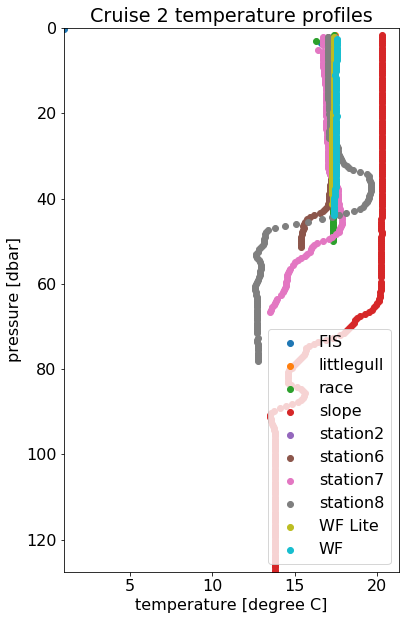

In [52]:
# Should be able to use the min and max of the data to determine the x axis limits
# but there is a zero point at surface FIS skews axis
#xlim = (np.nanmin(ctdcombined.temperature.values),np.nanmax(ctdcombined.temperature.values)+1)

plt.figure(figsize=(6,10))
for i in range(stnCounter):
    ctdcombined.isel(cast=i).plot.scatter('temperature','pressure',label=stnnames[i])
plt.legend(loc=4)
plt.xlim([11, 21])
#plt.xlim(*xlim)
plt.ylim(*ylim)
plt.title("Cruise 2 temperature profiles")

plt.savefig('Figures/Cruise2Temperature.png')